# Проект: Маркетинговая аналитика развлекательного приложения

В данной работе необходимо провести анализ данных развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

## Загрузка данных и подготовка к анализу

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Нам предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучим данные и выполним предобработку.

In [1]:
import pandas as pd

visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')
display(visits.head())
display(visits.info())
display(orders.head())
display(orders.info())
display(costs.head())
display(costs.info())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

Во всех трёх датасетов не наблюдается пропусков, однако во всех трёх столбцы с датами имеют тип object. Исправим это, предварительно переименовав столбцы согласно "змеиному регистру".

In [2]:
# Переименовываем столбцы
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

# Меняем типы данных столбцов с датами
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date


Проверим датасеты на наличие дубликатов.

In [3]:
print('Количество явных дубликатов в датафрейме visits:', visits.duplicated().sum())
print('Количество явных дубликатов в датафрейме orders:', orders.duplicated().sum())
print('Количество явных дубликатов в датафрейме costs:', costs.duplicated().sum())

Количество явных дубликатов в датафрейме visits: 0
Количество явных дубликатов в датафрейме orders: 0
Количество явных дубликатов в датафрейме costs: 0


Явных дубликатов нет. Проверим на неявные: выведем уникальные значения столбцов с типом данных object.

In [4]:
print(visits['region'].unique())
print(visits['device'].unique())
print(visits['channel'].unique())
print(costs['channel'].unique())

['United States' 'UK' 'France' 'Germany']
['iPhone' 'Mac' 'Android' 'PC']
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


Итак, дубликатов и пропусков нет, столбцы приведены к правильному стилю и типу данных. Можно идти дальше.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Будем использовать готовые функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [5]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()
    
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

Для начала составим профили пользователей. Вызовем функцию get_profiles. 

In [6]:
user_profiles = get_profiles(visits, orders, [], costs)
user_profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


Найдем минимальную и максимальную дату привлечения пользователей.

In [7]:
print('Минимальная дата привлечения пользователей: ', user_profiles['dt'].min())
print('Максимальная дата привлечения пользователей: ', user_profiles['dt'].max())

Минимальная дата привлечения пользователей:  2019-05-01
Максимальная дата привлечения пользователей:  2019-10-27


Видим, что в датасетах приведены данные о пользователях, привлеченных в период с 1 мая по 27 октября 2019 года, что соответствует с датами привлечения из ТЗ проекта.

Выясним теперь, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Для этого построим сводную таблицу из пользовательских профилей с группировкой по столбцу region.`

In [8]:
user_profiles.pivot_table(index = 'region', values = 'payer', aggfunc = ['count','mean'])

,count,mean
,payer,payer
region,,
France,17450,0.037994
Germany,14981,0.041119
UK,17575,0.039829
United States,100002,0.069019


В таблице приведены столбцы с количеством пользователей для разных стран и долей платящих из них. Явно выделяется США: количество пользователей и доля платящих в этой стране значительно превышает эти показатели для Европейских стран.

Теперь рассмотрим разбивку по устройствам, с которых пользователи проявляли активность. Построим аналогичную сводную таблицу, но сгруппируем теперь по столбцу "device".

In [9]:
user_profiles.pivot_table(index = 'device', values = 'payer', aggfunc = ['count','mean'])

,count,mean
,payer,payer
device,,
Android,35032,0.058518
Mac,30042,0.063644
PC,30455,0.050468
iPhone,54479,0.062079


Доля платящих на разных устройствах отличается мало(от 5% для пользователей PC и до 6.4% для пользователей Mac). По количеству пользователей среди остальных устройств выделяется iPhone (54.5 тыс. пользователей по сравнению с 30-35 тыс. для других устройств).

И, наконец, построим такую сводную таблицу с группировкой по источникам рекламы.

In [10]:
user_profiles.pivot_table(index = 'channel', values = 'payer', aggfunc = ['count','mean']).sort_values(by = ('count', 'payer'), ascending = False)

,count,mean
,payer,payer
channel,,
organic,56439,0.020553
FaceBoom,29144,0.122049
TipTop,19561,0.096007
OppleCreativeMedia,8605,0.027077
LeapBob,8553,0.030633
WahooNetBanner,8553,0.052964
RocketSuperAds,4448,0.079137
MediaTornado,4364,0.035747


Больше всего пользователей пришли не по рекламе, а "органически". Среди пользователей, пришедших с помощью разных рекламных источников, доля платящих сильно разнится (от 2.7% до 12.2%), при этом данный показатель имеет высокое значение для рекламных источников, из которых пришло наименьшее количество пользователей (11.3% из 'AdNonSense' и 10.5% из 'lambdaMediaAds'). Может, стоит перераспределить рекламный бюджет?

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем для этого профили пользователей.


Посчитаем общую сумму расходов на маркетинг. Для проверки работы функций и построения таблиц найдем сумму по двум таблицам: первоначальной таблице с рекламными расходами costs и по столбцу 'aquisition_cost' из полученной таблицы с профилями пользователей.

In [11]:
print('Расходы на маркетинг по исходной таблице = ', costs['costs'].sum())
print('Расходы на маркетинг по таблице с профилями пользователей = ', user_profiles['acquisition_cost'].sum())

Расходы на маркетинг по исходной таблице =  105497.30000000002
Расходы на маркетинг по таблице с профилями пользователей =  105497.29999999999


С высокой точностью значения совпадают. Значит, все правильно.

Выясним теперь, как рекламный бюджет был распределён по источникам. По исходной таблице построим сводную с группировкой по источникам. В качестве значений выберем столбец 'costs' с агрегирующей функцией суммы.

In [12]:
costs.pivot_table(index = 'channel', values = 'costs', aggfunc = 'sum').sort_values(by = 'costs' ,ascending = False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Визуализируем динамику изменения расходов на рекламу по неделям и месяцам с разбивкой по источникам.

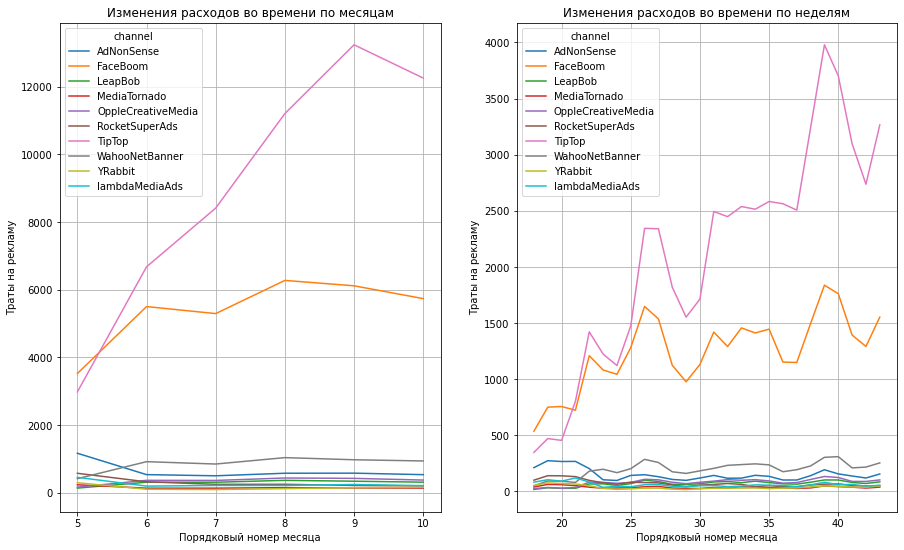

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 9))

costs['month'] = pd.to_datetime(costs['dt']).dt.month # Создаем столбец с месяцами
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week # Создаем столбец с неделями

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

(
    costs.pivot_table(columns = 'channel', index = 'month', values = 'costs', aggfunc = 'sum')
    .plot(ax = ax1, grid = True, ylabel = 'Траты на рекламу', xlabel = 'Порядковый номер месяца', title = 'Изменения расходов во времени по месяцам')
)

(
    costs.pivot_table(columns = 'channel', index = 'week', values = 'costs', aggfunc = 'sum')
    .plot(ax = ax2, grid = True, ylabel = 'Траты на рекламу', xlabel = 'Порядковый номер месяца', title = 'Изменения расходов во времени по неделям')
);

Из графиков видно, что очень большие расходы идут в рекламные источники 'TipTop' и 'FaceBoom'. Более того, со временем расходы на рекламу в этих источниках растут. Интересно, так растёт стоимость на рекламу, или компания сама вкладывает все больше денег в эти источники для привлечения аудитории? Для других же источников расходы значительно меньше и примерно сохраняются во времени ( это видно из графиков с разбиением по месяцам). 

Чтобы разобраться, как оправдывают себя расходы на рекламу в разных источниках, построим таблицу с показателем CAC для разных источников.

In [14]:
user_profiles.pivot_table(index = 'channel', values= 'acquisition_cost').sort_values(by = 'acquisition_cost', ascending = False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Средняя цена привлечения пользователя сильно разнится для разных источников. Источник 'TipTop' сильно "опережает" остальные: привлечение одного клиента из данного источника обходится компании аж в 2.8 доллара, когда для остальных источников этот показатель имеет значение равное или меньше 1.1 доллара. *Тревожный звоночек*

### Оценка окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучите графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?


С помощью введенных выше функций построим таблицы LTV и ROI и их динамики. При построении таблиц не будем учитывать органических пользователей, чтобы рассчитать окупаемость только по "купленным" пользователям.

In [15]:
from datetime import datetime, timedelta
import numpy as np

observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

result_raw, ltv, ltv_history, roi, roi_history = get_ltv(user_profiles[user_profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False )


Для проверки окупаемости рекламы в целом построим графики через введенную выше функцию с помощью таблиц показателей, которые мы получили в предыдущей ячейке.

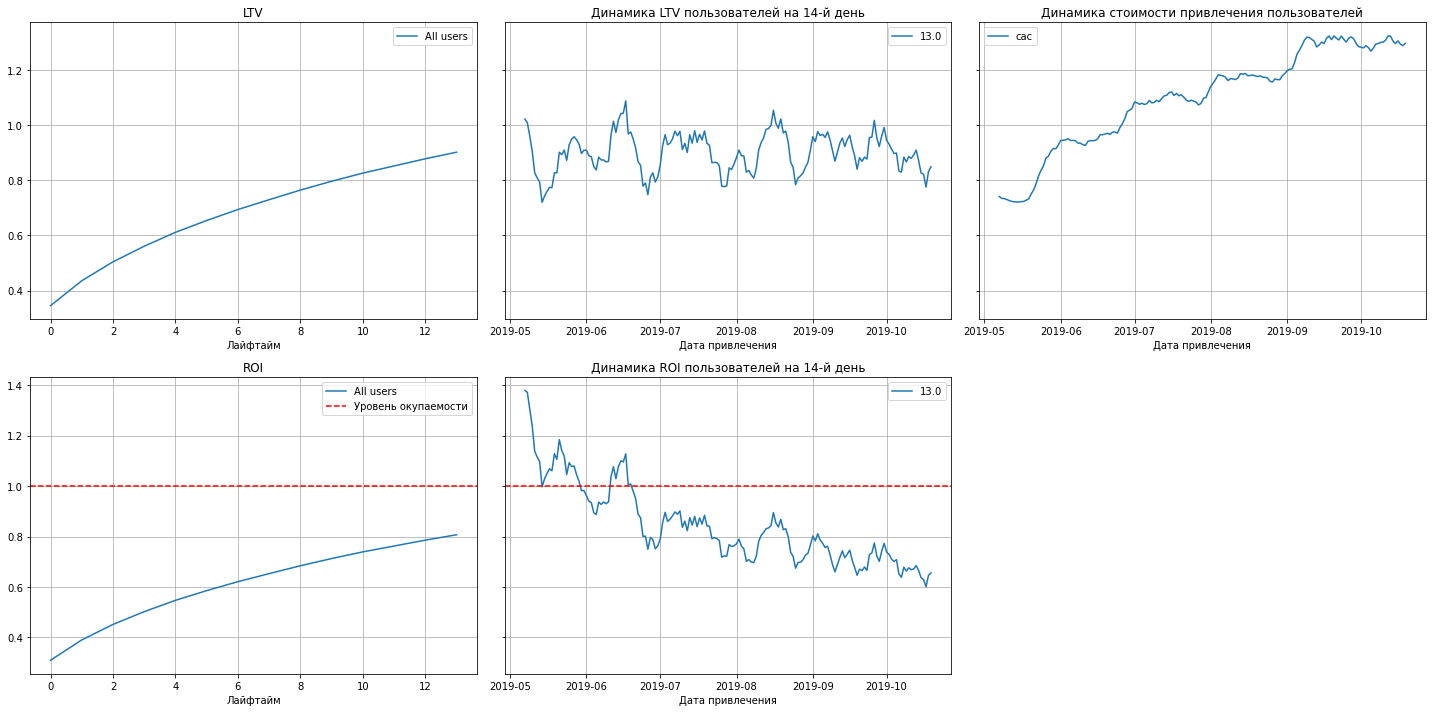

In [16]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window = 7)

Графики говорят, что дела плохи. График динамики стоимости привлечения пользователей имеет тренд к росту, тогда как динамика LTV в среднем сохраняется. Из-за этого показатель ROI падает со временем, и уже с середины июля инвестиции в рекламу перестали окупаться вовсе. Однозначно, надо что-то предпринимать, потому что с такой динамикой ROI компания может понести еще большие убытки в ближайшем будущем.

Построим и изучим графики конверсии и удержания пользователей. Может, там найдутся какие-то точки роста.

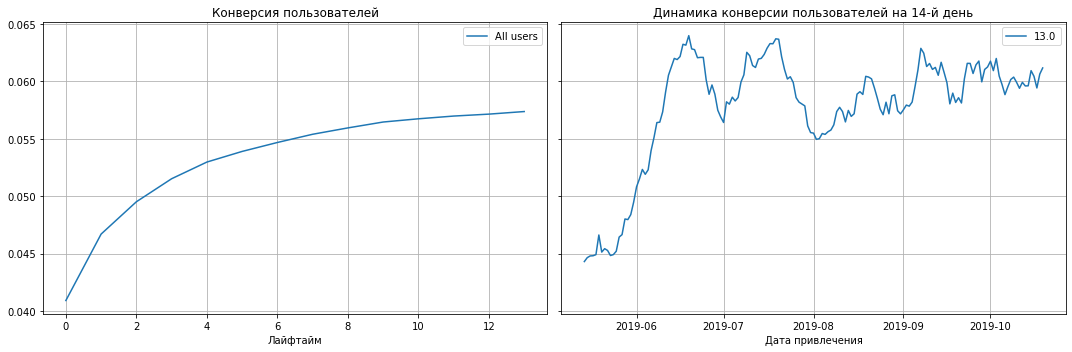

In [17]:
result_conv, conversion, conversion_history = get_conversion(user_profiles, orders, observation_date, horizon_days)
plot_conversion(conversion, conversion_history, horizon_days, window = 14)

Без учета сезонности динамика конверсии примерно сохраняется во времени. Сама же конверсия для всех пользователей на 14-й день составляет примерно 58%. Не так плохо, но есть, куда расти.

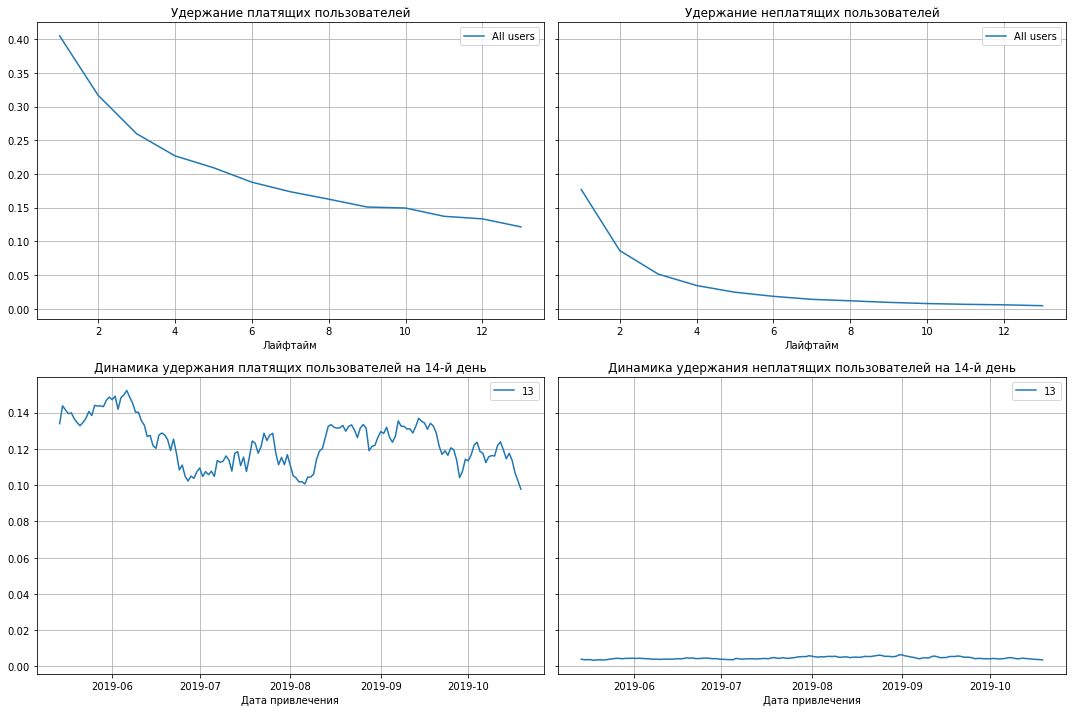

In [18]:
result_ret, retention, retention_history = get_retention(user_profiles, visits, observation_date, horizon_days)

plot_retention(retention, retention_history, horizon_days, window = 14)

На графиках приведены удержание и ее динамика для платящих и неплатящих пользователей. Из них видно, что с удержанием все плохо. Поскольку это развлекательное приложение, а не интернет-магазин, в котором пользователи оформили заказ и могут продолжительное время не возвращаться, удержание в ~12% для платящих и <1% для неплатящих с лайфтаймом в 14 дней - низкий показатель, который можно и нужно повышать. Компании стоит продумать обновление приложения для поддержания интереса и повышения удержания пользователей, а также увеличения лояльности к неплатящим пользователям, ведь спустя время неплатящий пользователь может превратиться в платящего.

Выше мы выяснили, что рекламные инвестиции не окупаются. Рассмотрим LTV, CAC и ROI с разбивкой по разным признакам, чтобы понять, как лучше перераспределить рекламный бюджет, чтобы выйти в плюс.

Для начала построим графики в разбивке по регионам пользователей. Для этого при построении таблиц показателей укажем dimensions = ['region']

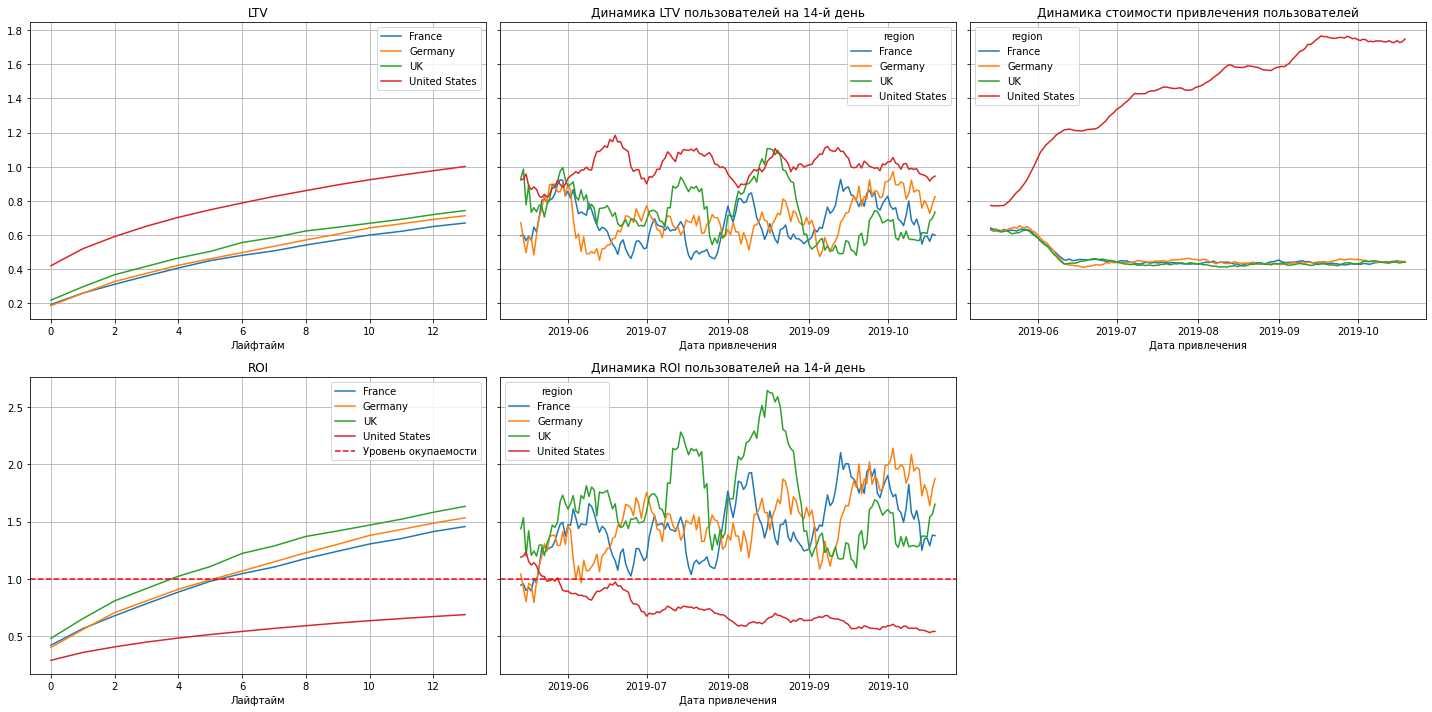

In [19]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(user_profiles[user_profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['region'], ignore_horizon=False )
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window = 14)

Первая причина - это США. Несмотря на то, что LTV пользователей из США значительно больше LTV пользователей из других регионов, стоимость привлечения там очень высока и не перестает расти на момент анализа, из-за чего ROI постоянно падает. В других регионах CAC в разы меньше и не изменяется во времени, а ROI не изменяется или даже имеет небольшой прирост во времени. Это весомый повод отказаться от рекламных кампаний в США.

Перейдем к построению графиков с разбивкой по устройствам.

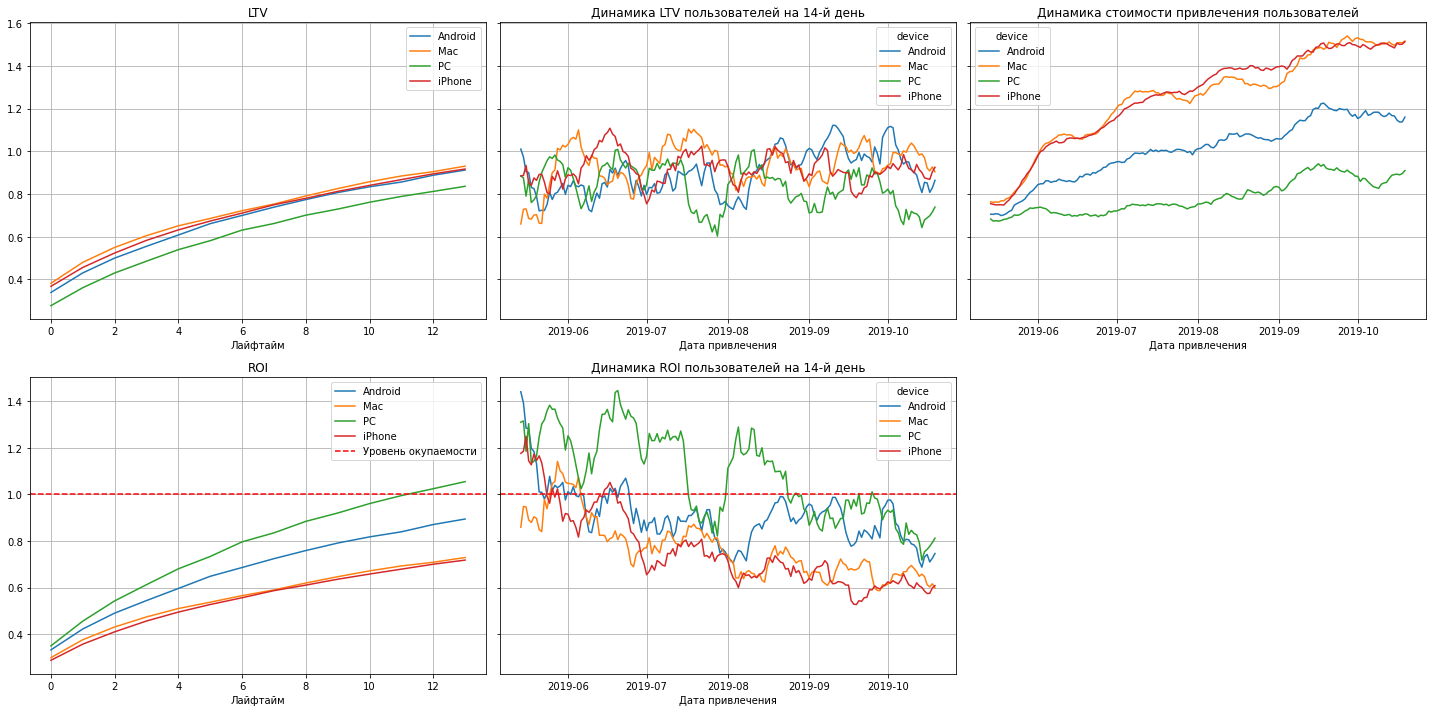

In [20]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(user_profiles[user_profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['device'], ignore_horizon=False )
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window = 14)

За весь период исследования инвестиции на рекламу, как показывает график ROI, окупают только пользователи PC. Однако, у всех платформ (в том числе и у PC) динамика ROI отрицательная, из-за этого бессмысленно перераспределять рекламный бюджет. От реклам на всех платформах отказаться не получится. Нужно работать с другими показателями.

И, наконец, выведем графики с разбивкой по рекламным каналам.

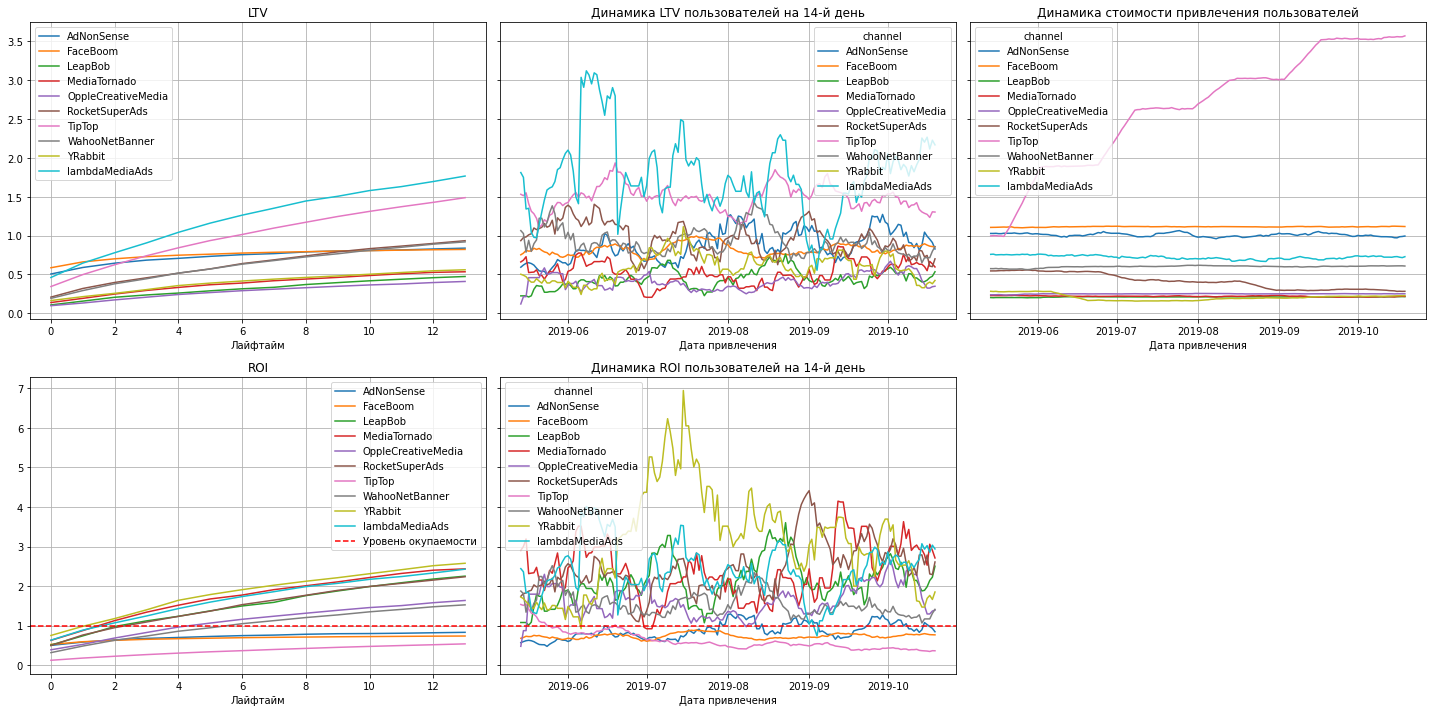

In [21]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(user_profiles[user_profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['channel'], ignore_horizon=False )
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window = 14)

Из-за большого количества рекламных каналов графики получились нагроможденными. Тем не менее, по графикам ROI и динамики ROI видно, что пользователи из источникв AdNonSense, FaceBoom и TipTop не окупают затраты на рекламу. Более того, как следует из динамики стоимости привлечения, TipTop ежемесячно повышает стоимость размещения рекламы. Целесообразным будет решение отказаться от проведения рекламных кампаний в данных источниках.

## Заключение


В данном проекте был произведен анализ данных о посещениях и покупках пользователей в развлекательном приложении Procrastinate Pro+, а также рекламных затратах компании за период с 1 мая по 27 октября 2019 года. Целью исследования являлось выяснение причин убытков компании и составление рекомендаций по улучшению показателей для отдела маркетинга.

**Основные выводы и рекомендации**:
- Для всех пользователей приложения за исследуемый период ROI стремительно падает, компания несет убытки.
- В разбивке по регионам пользователей большую часть составляют американцы (почти 67%), они же имеют наибольшую долю платящих (6.9%, в остальных регионах долю платящих составляет менее 4.1%). Это было бы хорошим поводом вкладываться в рекламу в США еще больше, однако графики ROI и его динамики подсказывают нам сделать обратное: показатель лежит значительно ниже уровня окупаемости и стремительно падает. В других регионах ROI медленно растет, а CAC почти не изменяется. ***Рекомендация***: перераспределить рекламные расходы с США на другие регионы.
- Для всех устройств ROI за исследуемый период падает, и, начиная с конца августа, уже никакая платформа не окупает инвестиции на рекламу. По данному признаку нельзя дать определенные рекомендации по перераспределению рекламного бюджета, нужно искать точки роста в других разбивках.
- В разбивке по рекламным источникам сильно выделяется 'TipTop': ROI падает и на момент анализа составляет менее 50%. Это связано с постоянно растущей стоимостью привлечения пользователей, что видно из графика её динамики. С ежемесячным ростом этой величины можно также связать и падение ROI в разбивке по устройствам и в частности в регионе "США", поскольку характер роста стоимости привлечения их схож (это говорит о том, что 'TipTop' является очень популярным на всех платформах и в США). Также показатель ROI лежит ниже уровня окупаемости для рекламных источников 'FaceBoom' и 'AdNoSence'. Для остальных же динамика положительна. ***Рекомендация***: отказаться от рекламы в источниках 'TipTop', 'FaceBoom' и 'AdNoSence' как от приносящих убытки рекламных источников и перераспределить рекламный бюджет на другие компании.
- Динамика конверсии пользователей на 14-й день имеет тренд к росту, но при этом конверсия всех пользователей за исследуемый период достигает ~58%. Это не плохой показатель, но можно постараться повысить его будущими обновлениями.
- Удержание пользователей явно нуждается во внимании: на 14-й день лишь ~12% для платящих пользователей и ~1% для неплатящих, а динамика имеет тренд к уменьшению. ***Рекомендация***: Повысить заинтересованность аудитории и лояльность неплатящих пользователей к приложению путем обновлений и нововведений для улучшения удержания в приложении.